In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numexpr as ne
import math
from IPython.display import display, Math, HTML
import matplotlib.animation as animation
from scipy.optimize import minimize
from scipy.optimize import curve_fit

In [3]:
!rm latticegas.pyf
!python3 -m numpy.f2py latticegas.f90 -m latticegas -h latticegas.pyf
!python3 -m numpy.f2py -c latticegas.pyf latticegas.f90

Reading fortran codes...
	Reading file 'latticegas.f90' (format:free)
Post-processing...
	Block: latticegas
			Block: latticegas
				Block: init
				Block: metropolis
				Block: metropolis_driver
				Block: deallocate_
Post-processing (stage 2)...
	Block: latticegas
		Block: unknown_interface
			Block: latticegas
				Block: init
				Block: metropolis
				Block: metropolis_driver
				Block: deallocate_
Saving signatures to file "./latticegas.pyf"
running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "latticegas" sources
creating /tmp/tmpb_otmyo5/src.linux-x86_64-3.6
f2py options: []
f2py: latticegas.pyf
Reading fortran codes...
	Reading file 'latticegas.pyf' (format:free)
Post-processing...
	Block: latticegas
			Block: latticegas
				Block: init
				Block: metropolis
				Block: 

latticegas.f90:50:1:

  if (Np >= L*L) then
 1
latticegas.f90:51:1:

   print *,'Number of particles > number of sites !!!'
 1
latticegas.f90:52:1:

   STOP 'Too small lattice'
 1
latticegas.f90:53:1:

  endif
 1
latticegas.f90:57:1:

   do j=0,L-1
 1
latticegas.f90:58:1:

    lattice(i,j) = .false.
 1
latticegas.f90:59:1:

   end do
 1
latticegas.f90:65:1:

   do ! Loop until empty position found
 1
latticegas.f90:67:1:

    call random_number(rnd)
 1
latticegas.f90:68:1:

    x(i)=int(rnd(1)*L);  if (x(i)>=L) x(i)=L-1;
 1
latticegas.f90:69:1:

    y(i)=int(rnd(2)*L);  if (y(i)>=L) y(i)=L-1;
 1
latticegas.f90:70:1:

    if (lattice(x(i),y(i))) then
 1
latticegas.f90:72:1:

     cycle
 1
latticegas.f90:73:1:

    else
 1
latticegas.f90:74:1:

     lattice(x(i),y(i))=.true.
 1
latticegas.f90:88:1:

  do isubstep=1,Np ! Do all particles on average once every MC step
 1
latticegas.f90:160:1:

  call metropolis()
 1
latticegas.f90:161:1:

  if (mod(istep*Np,1) == 0) then
 1
latticegas.f90:

In [4]:
from latticegas import latticegas

# 1. Self-diffusion coefficient in a lattice gas model
Consider a finite square lattice with sites randomly occupied by particles with a given density $\rho$. The
particles can move randomly to empty nearest sites (two particles can not occupy the same site). It is an
example of a restricted random walk. A meaningful physical quantity is the self-diffusion coefficient $D$ of
an individual particle.$D$ is the limit $t \to \infty$ of $D(t)$, where $D(t)$ is given by:
\begin{equation*}
D(t) = \frac{1}{2dt}\langle\Delta R^2(t)\rangle,
\end{equation*}
with $d$ which is the dimensionality of the system and $\langle \Delta R^2(t)\rangle$ is the net instantaneous mean square
displacement per particle, averaged over all particles, after t units of time ($\langle$...$\rangle$ here indicates the average
over particles and not temporal averages).  
The dynamical model can be summarized by the following algorithm:
1. Occupy at random the $L × L$ sites of a square lattice with N particles subject to the condition thatno double occupancy is allowed, with the desired density $\rho = N/L^2 \leq 1$. Tag each particle, that is, distinguish it from the others, and record its initial position in an array.
2. At each step choose a particle (randomly, or, alternatively, in an ordered way) and one of its nearestneighbor sites at random. If the neighbor site is empty, the particle moves to this site; otherwise itdoes not. Loop over the particles.

Note 1: The measure of “time” in this context is arbitrary. The usual definition is that during one unit
of time or one Monte Carlo step, each particle on average attempts one jump. Time goes on even if the
particles do not move, i.e., the tentative move is not accepted.
Note 2: Consider periodic boundary conditions, but note that reliable results can be obtained only for
\begin{equation*}
\langle \Delta R^2(t) \rangle < (L/2)^2
\end{equation*}
(this sets a limit to number of MC steps). Otherwise, they could be affected by the imposed periodicity.

Do a Monte Carlo simulation to determine $D$ and its dependence on the particles concentration $\rho$.
See for instance the code latticegas.f90. Internal units for Monte Carlo time step and displacement
should be preferred. For comparison with a realistic situation, such as for instance diffusion in solids,
we may consider Monte Carlo time step equal to 1 ns and the unit length to $2 A$, properly rescaling the
internal quantities at the end of the calculations.


In [5]:
class gas_lattice:
    '''
    This class simulates a Monte Carlo dynamics for a 2D square lattice
    '''
    
    def __init__(self,L,Np,Nsteps,deltat,a,seed= 50,gif_lattice=True, fortran=False, fpro=False):
        self.L = L
        self.Np = Np
        self.Nsteps = Nsteps
        self.p=np.zeros(self.Np)
        self.p_=np.zeros(self.Np)
        self.p_c=np.zeros(self.Np)
        self.t=np.zeros(Nsteps-1)
        self.drsqave=np.zeros(Nsteps-1)
        self.D=np.zeros(Nsteps-1)
        self.deltat=deltat
        self.a=a
        self.njumps=0
        self.nfail=0
        self.istep=0
        self.free=np.zeros(4)
        self.dxtrial=np.zeros(4)
        self.dytrial=np.zeros(4)
        self.lattice=np.zeros((self.L,self.L),dtype=bool)
        self.latticegif = np.zeros((self.Nsteps,self.L,self.L),dtype=bool)
        self.x=np.zeros(self.Np)
        self.y=np.zeros(self.Np)
        self.dx=np.zeros(self.Np)
        self.dy=np.zeros(self.Np)
        self.x_t=np.zeros((self.Nsteps,self.Np))
        self.y_t=np.zeros((self.Nsteps,self.Np))
        self.gif_lattice=gif_lattice
        self.fortran=fortran
        self.seed=seed
        self.fpro=fpro
        self.p_rho=0.0
        self.rng = np.random.default_rng(self.seed)
        
        
    def initialize(self):
        "Initialization"
        if self.fortran:
            if self.seed == 50:
                latticegas.seed=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]
            else:
                latticegas.seed=self.rng.integers(low=0,high=50, size=33)
                
            latticegas.l=self.L
            latticegas.np=self.Np
            latticegas.nsteps=self.Nsteps
            latticegas.deltat=self.deltat
            latticegas.a=self.a
            latticegas.init()
            self.lattice=latticegas.lattice
            self.x=latticegas.x
            self.y=latticegas.y
            self.dx=latticegas.dx
            self.dy=latticegas.dy
            
        else:
            if (self.Np >= self.L**2) :
                print('Number of particles > number of sites !!!')
            #print('Density Np/L^2=',self.Np/self.L**2)
            self.dxtrial[0]= 1  
            self.dxtrial[1]=-1   
            self.dxtrial[2]= 0 
            self.dxtrial[3]= 0
            
            self.dytrial[0]= 0  
            self.dytrial[1]= 0 
            self.dytrial[2]= 1 
            self.dytrial[3]=-1
            
            # Generate particles on lattice 
            for i in range(self.Np): 
            # Loop until empty position found
            #  To   be  on  safe  side,   check  that  upper   limit  not  reached
                rnd=self.rng.random(2)
                self.x[i]=int(rnd[0]*(self.L-1)) 
                self.y[i]=int(rnd[1]*(self.L-1))
                if self.lattice[int(self.x[i]),int(self.y[i])]:
                    # Position already filled, loop to find new trial 
                    i=i-1
                else:
                    self.lattice[int(self.x[i]),int(self.y[i])]=True
                    #Success, go  to next particle  
                
        if self.gif_lattice:
            self.latticegif[0]=self.lattice
    
    def MonteCarlo(self,Np):
        'Implementation of one Monte Carlo Step'
        if self.fortran:
            latticegas.metropolis()
            self.lattice=latticegas.lattice
            self.x=latticegas.x
            self.y=latticegas.y
            self.dx=latticegas.dx
            self.dy=latticegas.dy
        else:
            for isubstep in range(Np): # Do all particles on average once every MC step
                # Pick one particle at random 
                rnd1=self.rng.random(1)
                i=int(rnd1*(Np-1))
                # Find possible directions, store it in free() 
                nfree=0
                xnew=np.zeros(4)
                ynew=np.zeros(4)
                free=np.zeros(4)
                for j in range(4):
                    xnew[j]=self.x[i]+self.dxtrial[j]
                    if  xnew[j] > self.L-1:
                        xnew[j]=0
                    if xnew[j]<0:
                        xnew[j]=self.L-1 
                    
                    ynew[j]=self.y[i]+self.dytrial[j]
                    if  ynew[j] > self.L-1:
                        ynew[j]=0
                    if ynew[j]<0:
                        ynew[j]=self.L-1 
                    
                    if ((self.lattice[int(xnew[j]),int(ynew[j])])==False):
                        # Success: position free 
                        nfree=nfree+1 
                        free[nfree-1]=j
                # If no possible directions, get new particle 
                if (nfree == 0):
                    self.nfail=self.nfail+1 
                else:
                    self.njumps=self.njumps+1

                #  Pick  one of  the  possible directions  randomly  
                #  Note that  the dir>nfree  check here  really is  needed!  
                    rnd1=self.rng.random(1)
                    dir_=int(rnd1*(nfree-1))
                    j=free[dir_]

                # Now x(i),y(i) is old position and xnew(j),ynew(j) new 
                # Double check that new site really is free 
                    if self.lattice[int(xnew[int(j)]), int(ynew[int(j)])]:
                        print('ERROR:    THIS   SHOULD   BE   IMPOSSIBLE')
                        break
                    else:
            #Empty  old  position  and  fill  new
                        self.lattice[int(self.x[i]),int(self.y[i])]=False 
                        self.lattice[int(xnew[int(j)]),int(ynew[int(j)])]=True
                        self.x[i]=xnew[int(j)] 
                        self.y[i]=ynew[int(j)] 
                        self.dx[i]=self.dx[i]+self.dxtrial[int(j)]
                        self.dy[i]=self.dy[i]+self.dytrial[int(j)]

    def MonteCarlo_driver(self):
        self.initialize()
        self.x_t[self.istep]=self.x
        self.y_t[self.istep]=self.y
        t_=0.0
        for self.istep in range(self.Nsteps):
            self.MonteCarlo(self.Np)
            self.x_t[self.istep]=self.x
            self.y_t[self.istep]=self.y
            if self.gif_lattice:
                self.latticegif[self.istep]=self.lattice
            # Calculate  and print intermediate results
            # Get total displacement from dx,dy 
            dxsum=sum(self.dx)
            dysum=sum(self.dy) 
            dxsqsum=sum(self.dx**2)
            dysqsum=sum(self.dy**2)
            drsqave_=(dxsqsum+dysqsum)/self.Np
            if (t_>0.0):
            #  Get  diffusion coefficient  by  proper scaling
                self.drsqave[self.istep-1]=drsqave_
                self.D[self.istep-1]=(drsqave_*self.a*self.a)/(4*t_)
                self.t[self.istep-1]=t_
            t_=t_+self.deltat
        if self.fpro:
            latticegas.probability()
            self.p_rho=latticegas.p_rho
        if self.fortran:
            latticegas.deallocate_()
            
    def probability(self):
        for i in range(self.Np):
            for j in range(1,self.Nsteps-1):
                if self.x_t[j,i]!=self.x_t[j-1,i] or self.y_t[j,i]!=self.y_t[j-1,i]:#Particle finds a vacancy
                    self.p_[i]=self.p_[i]+1/self.Nsteps
                    if self.x_t[j+1,i]==self.x_t[j-1,i] and self.y_t[j+1,i]==self.y_t[j-1,i]:#Particle found the previous vacancy
                        self.p[i]=self.p[i]+1/self.Nsteps
                        self.p_c[i]=self.p[i]/self.p_[i]#Normalization
        return self.p_c
            
    def visualize_D(self):
        'Plot D(t)'
        plt.title("Diffusion Coefficient")
        plt.xlabel('Monte Carlo steps')
        plt.ylabel("Diffusion Coefficient")
        plt.plot(self.t,self.D,label=r'$D(t)$',color="#1E90FF")
        plt.legend()
        plt.show()
        
    def visualize_R(self):
        'Plot \Delta R^2(t)'
        #plt.rcParams.update({
         #   "text.usetex": True,
         #   "font.family": "serif",
         #   "font.serif": "Helvetica",
        #})
        plt.title(r"Mean Square Displacement")
        plt.xlabel('Monte Carlo steps')
        plt.ylabel(r"Mean Square Displacement")
        plt.plot(self.t,self.drsqave,label=r"$\langle \Delta R(t)^2 \rangle$",color="#1E90FF")
        plt.axhline(y=(self.L/2)**2,c='c',label=r"$(\frac{L}{2})^2$")
        plt.legend()
        plt.show()
        
    def plot_lattice(self):
        'Plot Lattice"'
        x,y = np.meshgrid(range(self.lattice.shape[0]),range(self.lattice.shape[1]))
        plt.scatter(x,y,c=self.latticegif[-1][x,y],label='Lattice')
        plt.title('Lattice')
        plt.show()
        
    def gif(self):
        "Gif of Gas Lattice Dynamics"
        self.lattice_gif(self.latticegif,self.L,self.Nsteps)
        
    @staticmethod
    def lattice_gif(lattice,L,frames):
        fig, ax = plt.subplots() 
        x,y = np.meshgrid(range(L),range(L))
        def update(frame):
            # clear the axis each frame
            ax.clear()
            # replot things
            ax.scatter(x,y,c=lattice[frame][x,y])
        ani = animation.FuncAnimation(fig, update, frames=frames, interval=80)
        ani.save('scatter.gif')
        video = ani.to_html5_video()
        display(HTML(video))
        plt.close()

In [6]:
# Set average time  between jumps and jump length Units is  s and cm 
# although actually this is not needed for the simulation 
deltat=1.0 # or 1d-9 for  1 ns 
a=1.0      # or 2e-8 for  2 Ang
L=20
Np=13
Nstep=100

(a) Study $\langle \Delta R^2(t) \rangle$ as a function of time for a fixed value of $\rho = 0.03$ and for a fixed number of particles (e.g., 13 particles in a 20×20 lattice). What do you see increasing time (within the limit mentioned above)? Make a fit and compare your result (the slope) with the expected behavior of a standard random walk.


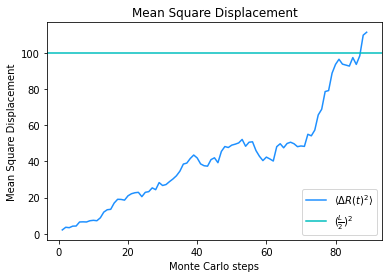

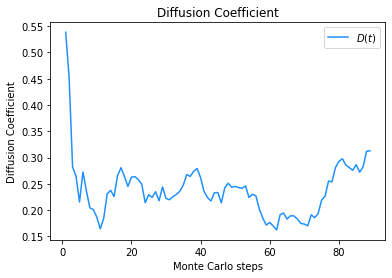

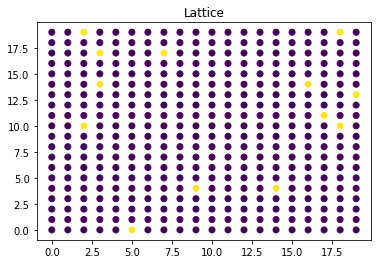

In [7]:
lattice=gas_lattice(20,13,90,deltat,a,fortran=True)
lattice.MonteCarlo_driver()
lattice.visualize_R()
lattice.visualize_D()
lattice.plot_lattice()

In [9]:
def linear(x,a,c):
    return a*x+c

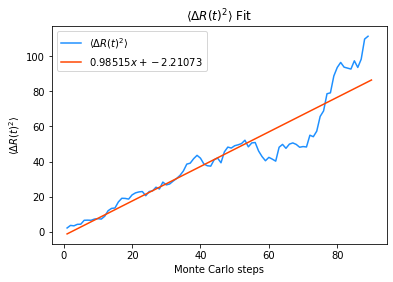

[ 0.98514968 -2.21073309]
[0.03887339 2.01430172]


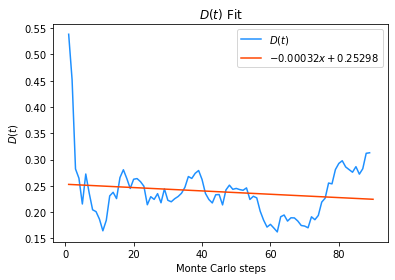

[-0.00031802  0.25298065]
[0.00022186 0.0114959 ]


In [10]:
#Fit R and D

popt, _ = curve_fit(linear, lattice.t, lattice.drsqave)
x_interval_for_fit = np.linspace(1, 90)
plt.title(r"$\langle \Delta R(t)^2 \rangle$ Fit")
plt.xlabel('Monte Carlo steps')
plt.ylabel(r"$\langle \Delta R(t)^2 \rangle$")
plt.plot(lattice.t, lattice.drsqave,label=r'$\langle \Delta R(t)^2 \rangle$',color="#1E90FF")
plt.plot(x_interval_for_fit, linear(x_interval_for_fit, *popt),color="#FF4500", label='${:.5f}x+{:.5f}$'.format(popt[0],popt[1]))
plt.legend()
plt.show()

print(popt)
print(np.sqrt(np.diag(_)))

popt, _ = curve_fit(linear, lattice.t, lattice.D)
x_interval_for_fit = np.linspace(1, 90)
plt.title(r"$D(t)$ Fit")
plt.xlabel('Monte Carlo steps')
plt.ylabel(r"$D(t)$")
plt.plot(lattice.t, lattice.D,label=r'$D(t)$',color="#1E90FF")
plt.plot(x_interval_for_fit, linear(x_interval_for_fit, *popt),color="#FF4500", label='${:.5f}x+{:.5f}$'.format(popt[0],popt[1]))
plt.legend()
plt.show()

print(popt)
print(np.sqrt(np.diag(_)))

(b) Repeat for $\rho = 0.2$.

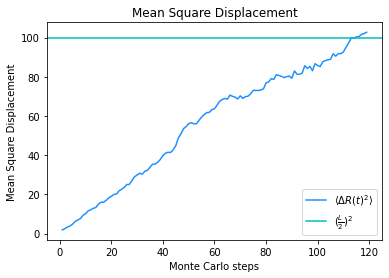

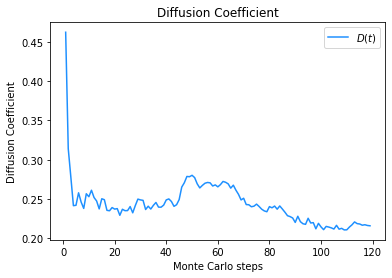

In [12]:
lattice=gas_lattice(L,80,120,deltat,a,fortran=True)
lattice.MonteCarlo_driver()
lattice.visualize_R()
lattice.visualize_D()

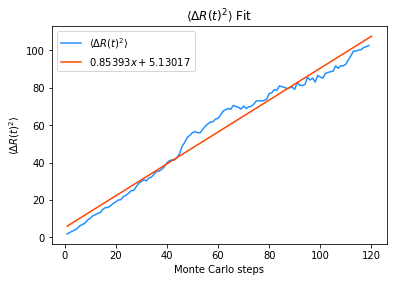

[0.85393338 5.13017376]
[0.01216306 0.84092435]


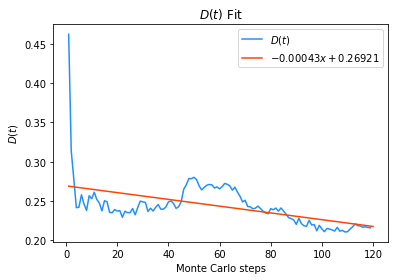

[-0.00043122  0.2692128 ]
[6.51936061e-05 4.50732584e-03]


In [13]:
#Fit \Delta R(t)^2 and D(t)

popt, _ = curve_fit(linear, lattice.t, lattice.drsqave)
x_interval_for_fit = np.linspace(1, 120)
plt.title(r"$\langle \Delta R(t)^2 \rangle$ Fit")
plt.xlabel('Monte Carlo steps')
plt.ylabel(r"$\langle \Delta R(t)^2 \rangle$")
plt.plot(lattice.t, lattice.drsqave,label=r'$\langle \Delta R(t)^2 \rangle$',color="#1E90FF")
plt.plot(x_interval_for_fit, linear(x_interval_for_fit, *popt),color="#FF4500", label='${:.5f}x+{:.5f}$'.format(popt[0],popt[1]))
plt.legend()
plt.show()

print(popt)
print(np.sqrt(np.diag(_)))

popt, _ = curve_fit(linear, lattice.t, lattice.D)
x_interval_for_fit = np.linspace(1, 120)
plt.title(r"$D(t)$ Fit")
plt.xlabel('Monte Carlo steps')
plt.ylabel(r"$D(t)$")
plt.plot(lattice.t, lattice.D,label=r'$D(t)$',color="#1E90FF")
plt.plot(x_interval_for_fit, linear(x_interval_for_fit, *popt),color="#FF4500", label='${:.5f}x+{:.5f}$'.format(popt[0],popt[1]))
plt.legend()
plt.show()

print(popt)
print(np.sqrt(np.diag(_)))

In [14]:
angular_coefficient=[]
std=[]
for j in range(1,50):
    lattice=gas_lattice(20,13,90,deltat,a,fortran=True,seed=j)
    lattice.MonteCarlo_driver()
    popt, _ = curve_fit(linear, lattice.t, lattice.drsqave)
    x_interval_for_fit = np.linspace(1, 90)
    angular_coefficient.append(popt[0])
    std.append(np.sqrt(np.diag(_))[0])
    
print("Angular Coefficient, rho=0.03:",np.mean(angular_coefficient))
print("Standard Deviation, rho=0.03:",np.mean(std))
    
angular_coefficient=[]
std=[]
for j in range(1,50):
    lattice=gas_lattice(20,80,120,deltat,a,fortran=True,seed=j)
    lattice.MonteCarlo_driver()
    popt, _ = curve_fit(linear, lattice.t, lattice.drsqave)
    x_interval_for_fit = np.linspace(1, 120)
    angular_coefficient.append(popt[0])
    std.append(np.sqrt(np.diag(_))[0])
    
print("Angular Coefficient, rho=0.2:",np.mean(angular_coefficient))
print("Standard Deviation, rho=0.2:",np.mean(std))

Angular Coefficient, rho=0.03: 0.9388459050878901
Standard Deviation, rho=0.03: 0.025992760540984778
Angular Coefficient, rho=0.2: 0.8831032485101171
Standard Deviation, rho=0.2: 0.008189667712213874


As we increase time we see that D tends to equilibrate, whereas $\langle R(t)^2 \rangle$ increases linearly.  
In these two cases we see what we could have imagined: the less molecules we consider the closer it gets to the one random walk.

(c) Plot $D(t)$ as a function of time: after a certain equilibration time, it fluctuates. Calculate the
amplitude of the fluctuations as a function of $t$ (from the distribution of data over the particles).
These fluctuations remain also by increasing $t$.

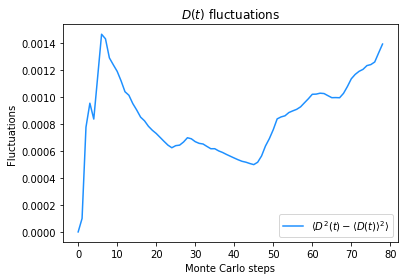

In [15]:
lattice=gas_lattice(L,13,90,deltat,a,fortran=True)
lattice.MonteCarlo_driver()

D_fluctuations=[]
for i in range(11,90):
    D_fluctuations.append(np.var(lattice.D[10:i]))
    
plt.title("$D(t)$ fluctuations")
plt.xlabel('Monte Carlo steps')
plt.ylabel('Fluctuations')
plt.plot(D_fluctuations[:],label=r'$\langle D^2(t)-\langle D(t) \rangle ^2 \rangle$',color="#1E90FF")
plt.legend()
plt.show()

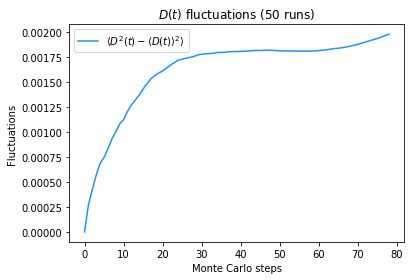

In [8]:
D_fluctuations=[]
for i in range(11,90):
    D_f=[]
    for j in range(1,100):
        lattice=gas_lattice(20,13,90,deltat,a,fortran=True,seed=j)
        lattice.MonteCarlo_driver()
        D_f.append(np.var(lattice.D[10:i]))
    D_fluctuations.append(np.mean(D_f))

plt.title("$D(t)$ fluctuations (50 runs)")
plt.xlabel('Monte Carlo steps')
plt.ylabel('Fluctuations')
plt.plot(D_fluctuations[:],label=r'$\langle D^2(t)-\langle D(t) \rangle ^2 \rangle$',color="#1E90FF")
plt.legend()
plt.show()

As we can see from the plot the fluctuations reach equilibrium.

(d) In order to estimate $D$, which is defined as the limit of $D(t)$ for $t \to \infty$, do a temporal average
$\langle D(t) \rangle_T$ ($\langle \text{...} \rangle_T$ here indicates a ”global” temporal average on $t$ from $0$ to $T$ or some block average).
Plot together $D(t)$ and $\langle D(t) \rangle_T$ . Change the seed, do another run and compare $\langle D(t) \rangle_T$ with the previous results. An estimate of $D$ can be obtained by averaging $\langle D(t) \rangle_T$ over different runs.

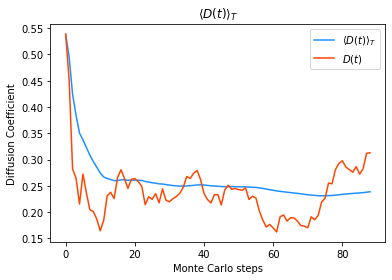

In [17]:
D_T=[]

lattice=gas_lattice(L,13,90,deltat,a,fortran=True)
lattice.MonteCarlo_driver()

for i in range(1,90):
    D_T.append(np.mean(lattice.D[:i]))
    
plt.title(r"$\langle D(t) \rangle_T$")
plt.xlabel('Monte Carlo steps')
plt.ylabel('Diffusion Coefficient')
plt.plot(D_T,label=r'$\langle D(t) \rangle_T$',color="#1E90FF")
plt.plot(lattice.D,label=r'$D(t)$',color="#FF4500")
plt.legend()
plt.show()

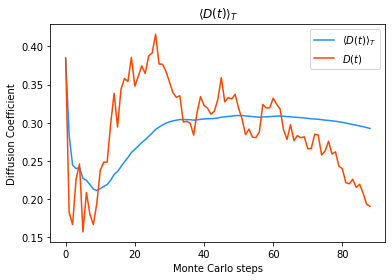

In [18]:
D_T=[]

lattice=gas_lattice(L,13,90,deltat,a,fortran=True, seed=1)
lattice.MonteCarlo_driver()

for i in range(1,90):
    D_T.append(np.mean(lattice.D[:i]))
    
plt.title(r"$\langle D(t) \rangle_T$")
plt.xlabel('Monte Carlo steps')
plt.ylabel('Diffusion Coefficient')
plt.plot(D_T,label=r'$\langle D(t) \rangle_T$',color="#1E90FF")
plt.plot(lattice.D,label=r'$D(t)$',color="#FF4500")
plt.legend()
plt.show()

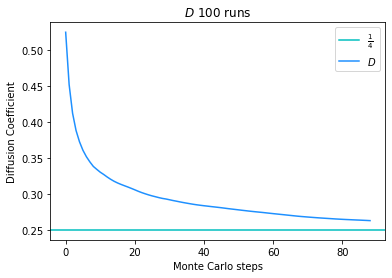

In [23]:
D_T_average=[]

for i in range(1,90):
    D_T=[]
    for j in range(1,51):
        lattice=gas_lattice(L,13,90,deltat,a,fortran=True,seed=j)
        lattice.MonteCarlo_driver()
        D_T.append(np.mean(lattice.D[:i]))
    D_T_average.append(np.mean(D_T))

D_T_average=np.array(D_T_average)
plt.title(r"$D$ 100 runs")
plt.xlabel(r'Monte Carlo steps')
plt.ylabel('Diffusion Coefficient')
plt.axhline(y=0.25,c='c',label=r"$\frac{1}{4}$")
plt.plot(D_T_average,label=r'$D$',color="#1E90FF")
plt.legend()
plt.show()

We can see that the average mitigates the fluctuations, the plot converges to the value 1/2Dt.

(e) Better statistics for $D(t)$ (and consequently for $D$) can be obtained by calculating $\langle\Delta R^2(t)\rangle$ as average over many particles (i.e., for a given $\rho$, considering a lattice with $L$ as large as possible; it is suggested $L \geq 40$). Verify that fluctuations of $D(t)$ (and the deviations of $\langle D(t) \rangle_T$ over more runs from its mean value) are proportional to the inverse square root of the number of particles.

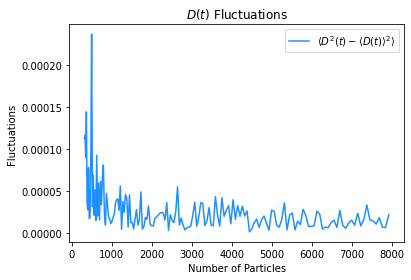

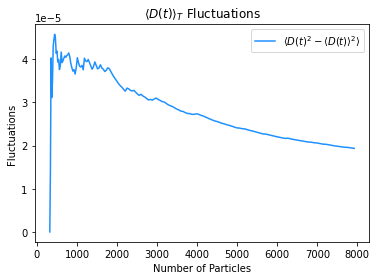

In [9]:
D=[]
D_T=[]
D_var=[]
D_T_var=[]
N_p=[]
rho=0.2

for i in range(40,200):
    Np=int(rho*i**2)
    lattice=gas_lattice(i,Np,Nstep,deltat,a,fortran=True)
    lattice.MonteCarlo_driver()
    N_p.append(Np)
    D_var.append(np.var(lattice.D[15:]))
    D_T.append(np.mean(lattice.D[15:]))
    D_T_var.append(np.var(D_T))
    
    
plt.title("$D(t)$ Fluctuations")
plt.xlabel(r'Number of Particles')
plt.ylabel('Fluctuations')
plt.plot(N_p,D_var,label=r'$\langle D^2(t)-\langle D(t) \rangle ^2 \rangle$',color="#1E90FF")
plt.legend()
plt.show()

plt.title(r"$\langle D(t) \rangle_T$ Fluctuations")
plt.xlabel(r'Number of Particles')
plt.ylabel('Fluctuations')
plt.plot(N_p,D_T_var,label=r'$\langle D(t)^2-\langle D(t) \rangle ^2 \rangle$',color="#1E90FF")
plt.legend()
plt.show()

In [10]:
def inverse_square(x,a):
    return a/np.sqrt(x)

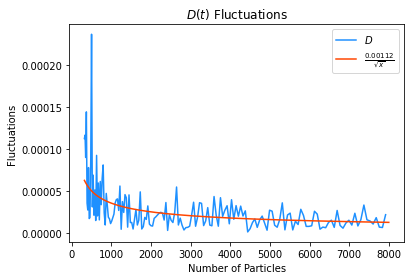

[0.00111755]
[7.57172346e-05]


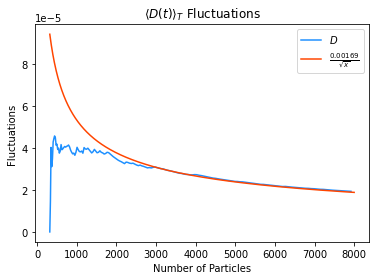

[0.00168698]
[4.10406484e-06]


In [11]:
popt, _ = curve_fit(inverse_square, N_p[70:],D_var[70:] )
x_interval_for_fit = np.linspace(320,8000,1000)
plt.title("$D(t)$ Fluctuations")
plt.xlabel(r'Number of Particles')
plt.ylabel('Fluctuations')
plt.plot(N_p,D_var,label=r'$D$',color="#1E90FF")
plt.plot(x_interval_for_fit, inverse_square(x_interval_for_fit, *popt),color="#FF4500", label='$ \\frac{{{:.5f}}}{{\\sqrt{{x}}}}$'.format(popt[0]))
plt.legend()
plt.show()

print(popt)
print(np.sqrt(np.diag(_)))

popt, _ = curve_fit(inverse_square, N_p[70:], D_T_var[70:])
x_interval_for_fit = np.linspace(320,8000,1000)
plt.title(r"$\langle D(t) \rangle_T$ Fluctuations")
plt.xlabel(r'Number of Particles')
plt.ylabel('Fluctuations')
plt.plot(N_p,D_T_var,label=r'$D$',color="#1E90FF")
plt.plot(x_interval_for_fit, inverse_square(x_interval_for_fit, *popt),color="#FF4500", label='$ \\frac{{{:.5f}}}{{\\sqrt{{x}}}}$'.format(popt[0]))
plt.legend()
plt.show()

print(popt)
print(np.sqrt(np.diag(_)))

From the latter plot it is explicit the inverse square root behaviour.

(f) Study the dependence of $D$ on the concentration, using for instance $\rho=0.1, 0.2, 0.3, 0.5$, and $0.7$.
You should find that $D$ is a monotonically decreasing function of $\rho$. Why?

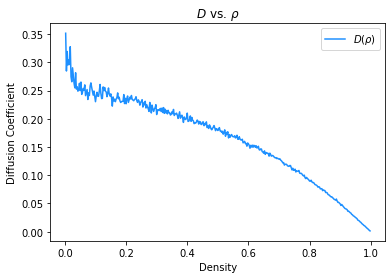

In [12]:
D_average=[]
rho=[]
L=20

for i in range(1,L**2):
    D_T_average=[]
    for j in range(1,11):
        lattice=gas_lattice(L,i,Nstep,deltat,a,fortran=True,seed=j)
        lattice.MonteCarlo_driver()
        D_T_average.append(np.mean(lattice.D))
    D_average.append(np.mean(D_T_average))
    rho.append(i/L**2)
    

plt.title(r"$D$ vs. $\rho$")
plt.xlabel(r'Density')
plt.ylabel('Diffusion Coefficient')
plt.plot(rho[:],D_average[:],label=r'$D(\rho)$',color="#1E90FF")
plt.legend()
plt.show()

In [13]:
def arctan(x,a,b,c,d):
    return a*np.arctan(b*(c-x))+d

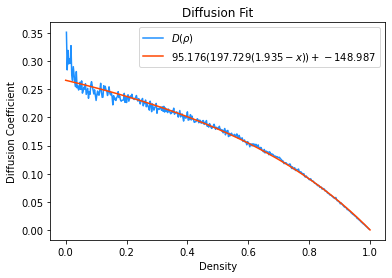

[  95.17555384  197.7293407     1.93506629 -148.98653736]
[       nan        nan 0.03782773        nan]


/home/s289217/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


In [15]:
popt, _ = curve_fit(arctan, rho[:],D_average[:] )
x_interval_for_fit = np.linspace(0,1,1000)
plt.title(r"Diffusion Fit")
plt.xlabel('Density')
plt.ylabel('Diffusion Coefficient')
plt.plot(rho[:],D_average[:],label=r'$D(\rho)$',color="#1E90FF")
plt.plot(x_interval_for_fit, arctan(x_interval_for_fit, *popt),color="#FF4500", label=r'${:.3f} ({:.3f}({:.3f}-x))+{:.3f}$'.format(popt[0],popt[1],popt[2],popt[3]))
plt.legend()
plt.show()

print(popt)
print(np.sqrt(np.diag(_)))


As we can see from the plots, D is monotically decreasing in density.  
This is due to the number of density of particles: the more the particles we consider, the less they can move.

(g) To gain some insight into this dependence, determine the dependence on $\rho$ of the probability that if
a particle jumps to a vacancy at time $t$, it returns to its previous position at time $t + 1$. Is there a
qualitative relation between the density dependence of $D$ and this probability?

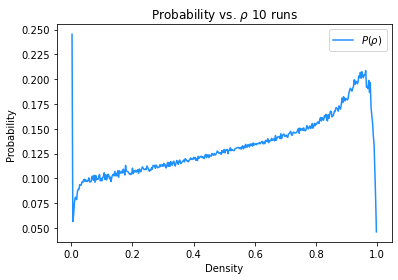

In [16]:
p_average=[]
rho=[]
L=20

for i in range(1,L**2):
    p=[]
    for j in range(1,11):
        lattice=gas_lattice(L,i,Nstep,deltat,a,fortran=True,seed=j)
        lattice.MonteCarlo_driver()
        p.append(np.mean(lattice.probability()))
    p_average.append(np.mean(p))
    rho.append(i/L**2)
    

plt.title("Probability vs. $\\rho$ 10 runs")
plt.xlabel(r'Density')
plt.ylabel('Probability ')
plt.plot(rho[:],p_average[:],label=r'$P(\rho)$',color="#1E90FF")
plt.legend()
plt.show()

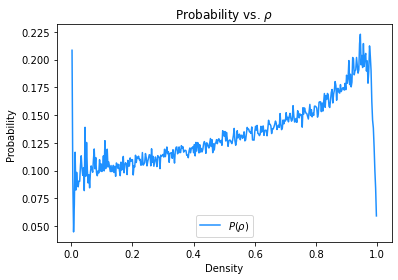

In [17]:
p=[]
rho=[]


for i in range(1,L**2):
    lattice=gas_lattice(L,i,Nstep,deltat,a,fortran=True)
    lattice.MonteCarlo_driver()
    p.append(np.mean(lattice.probability()))
    rho.append(i/L**2)

    
    
plt.title("Probability vs. $\\rho$")
plt.xlabel(r'Density')
plt.ylabel('Probability ')
plt.plot(rho[:],p[:],label=r'$P(\rho)$',color="#1E90FF")
plt.legend()
plt.show()

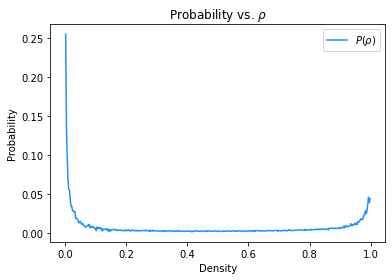

In [20]:
plt.title(r"Probability vs. $\rho$")
plt.xlabel('Density')
plt.ylabel(r'Probability')
plt.plot(*np.loadtxt("Uniform.dat",unpack=True),label=r'$P(\rho)$', color="#1E90FF")
plt.legend()
plt.show()

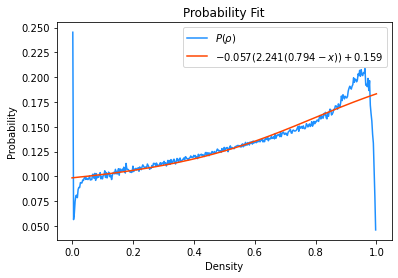

[-0.0568117   2.2410324   0.79404473  0.15862756]
[0.01526996 0.59838585 0.10356132 0.01213   ]


In [19]:
popt, _ = curve_fit(arctan, rho[:],p_average[:] )
x_interval_for_fit = np.linspace(0,1,1000)
plt.title(r"Probability Fit")
plt.xlabel('Density')
plt.ylabel('Probability')
plt.plot(rho[:],p_average[:],label=r'$P(\rho)$',color="#1E90FF")
plt.plot(x_interval_for_fit, arctan(x_interval_for_fit, *popt),color="#FF4500", label=r'${:.3f}  ({:.3f}({:.3f}-x))+{:.3f}$'.format(popt[0],popt[1],popt[2],popt[3]))
plt.legend()
plt.show()

print(popt)
print(np.sqrt(np.diag(_)))

As we can see both diffusion coefficient and vacancy probability are decreasing functions in density, reflecting what we have previously said: as density grows vacancies decrease.
This is the inuitive idea of diffusion.
We expect that in the one particle case, the vacancy probability is 1/4 (in three dimensions is 8, and in d dimensions is 1/2^d).
We see that we have to consider an equilibration phase, in which the particles have to "notice" other particles, thus the probability is almost 1/4.